In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np

In [2]:
#look at table E
E = pd.read_csv("E.csv")
print(len(E))
E.head()

5194


,Album,Artist,Genre,Label,Producer,Release Date,Meta Score
0,Black and White Rainbows,Bush,"['pop rock', 'alternative rock']","['zuma rock records', 'caroline']","['bob rock', 'gavin rossdale']",Mar 10 2017,49.0
1,Different Creatures,Circa Waves,['pop rock'],['virgin emi'],['alan moulder'],Mar 10 2017,78.0
2,Elektrac,Shobaleader One,['electronic'],"['warp', 'wrap']",['squarepusher'],Mar 10 2017,71.0
3,Packs,Your Old Droog,"['hip hop', 'rap']","['droog', 'droog recordings', 'fat beats']","['edan', '88 keys', 'alchemist', 'the purist',...",Mar 10 2017,81.0
4,Captain California,Murs,"['hip hop', 'rap']",['strange music'],"['wax roof', 'seven', 'dj rek', 'dj fresh', 'a...",Mar 10 2017,82.0


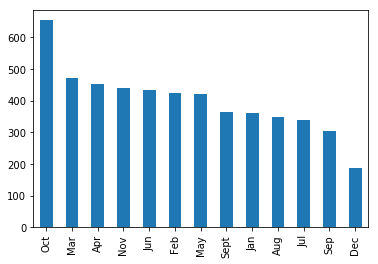

In [3]:
#plot by month release date
months = E["Release Date"].str.split(" ").apply(lambda x: x[0])
months.value_counts().plot(kind="bar")

E_months = E.copy()
E_months["Release Date"] = months

In [4]:
#show top genre pairs
E_filtered = E[pd.notnull(E['Meta Score'])]
genres = E_filtered["Genre"].tolist()

def create_pairs(genre_list):
    pairs = []
    indicies = xrange(len(genre_list))
    combos = itertools.combinations(indicies,2)
    for i,j in combos:
        p = [genre_list[i],genre_list[j]]
        p.sort()
        pairs.append(tuple(p))
    return pairs

def strlist_to_list(genre_list):
    if type(genre_list) != str:
        genre_list = ""
    for c in ["[","]","'"]:
        genre_list = genre_list.replace(c,"")
    genre_list = genre_list.split(",")
    genre_list = map(lambda x: x.strip(),genre_list)
    return genre_list

genre_lists = map(strlist_to_list,genres)
print(genre_lists[0:10])
pairs = []
for genre_list in genre_lists:
    p = create_pairs(genre_list)
    pairs.extend(p)

counts = collections.Counter(pairs)
print(counts.most_common(10))

[['pop rock', 'alternative rock'], ['pop rock'], ['electronic'], ['hip hop', 'rap'], ['hip hop', 'rap'], ['pop rock', 'alternative rock'], ['pop rock', 'electronica'], ['pop rock', 'post punk'], ['electronic'], ['pop rock', 'indie pop', 'indie rock']]
[(('indie rock', 'pop rock'), 97), (('hip hop', 'rap'), 82), (('alternative rock', 'pop rock'), 67), (('pop rock', 'rock'), 63), (('pop', 'pop rock'), 37), (('indie pop', 'pop rock'), 29), (('r&b', 'soul'), 24), (('pop rock', 'punk rock'), 22), (('hard rock', 'pop rock'), 22), (('pop', 'r&b'), 21)]


In [5]:
#Build regression model based on genre

#Make one hot encoding
from collections import defaultdict

#create genres set
genres_dict = defaultdict(int)
for l in genre_lists:
    for g in l:
        if g != "":
            genres_dict[g] += 1

#create mapping of genre to feature
genre_mapping = {}
i = 0
for g,count in genres_dict.items():
    if count > 2: #needs to occur at least 2 times for us to consider it
        genre_mapping[g] = i
        i += 1
print "One hot mapping: " + str(genre_mapping)

#create feature vectors
X = []
for l in genre_lists:
    x = [0 for i in xrange(len(genre_mapping))]
    for genre in l:
        if genre in genre_mapping:
            x[genre_mapping[genre]] = 1
    X.append(x)

One hot mapping: {'folk rock': 0, 'dance': 1, 'post punk': 2, 'edm': 24, 'power pop': 4, 'post rock': 5, 'progressive metal': 6, 'heavy metal': 7, 'melodic death metal': 104, 'alternative': 41, 'alternative rock': 9, 'dance rock': 11, 'experimental pop': 19, 'glam rock': 13, 'stoner rock': 14, 'heartland rock': 15, 'experimental hip hop': 10, 'holiday': 17, 'experimental rock': 18, 'west coast hip hop': 20, 'psychedelic pop': 21, 'indie folk': 22, 'art pop': 23, 'country rock': 25, 'emo': 26, 'noise pop': 27, 'psychedelic rock': 28, 'hip hop': 50, 'soundtracks': 30, 'gangsta rap': 53, 'post grunge': 37, 'gospel': 32, 'classical': 78, 'house': 33, 'alternative country': 34, 'new wave': 35, 'neo psychedelia': 38, 'blues': 39, 'alt country': 40, 'folk': 42, 'garage rock': 43, 'alternative pop': 84, 'indie rock': 44, 'electronica': 45, 'electronic rock': 46, 'r&b': 47, 'alternative hip hop': 16, 'international': 48, 'christmas': 49, 'trap': 29, 'shoegazing': 51, 'latin': 36, 'groove metal'

In [6]:
labels = E_filtered["Meta Score"].tolist()

#get train test split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,y_train,y_test = train_test_split(X,labels,test_size=.15,random_state=6)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import sklearn.metrics
clf = LinearRegression()
clf.fit(Xtrain,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Train MAE: 5.38845095878
Test MAE: 6.24549758887


(array([   3.,    3.,   29.,  140.,  134.,   86.,   38.,   12.,    5.,    1.]),
 array([-27.97742753, -21.77978951, -15.58215149,  -9.38451347,
         -3.18687545,   3.01076258,   9.2084006 ,  15.40603862,
         21.60367664,  27.80131466,  33.99895268]),
 <a list of 10 Patch objects>)

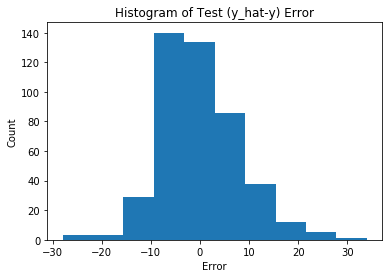

In [12]:
train_predictions = clf.predict(Xtrain)
test_predictions = clf.predict(Xtest)
train_mae = sklearn.metrics.mean_absolute_error(y_train,train_predictions)
test_mae = sklearn.metrics.mean_absolute_error(y_test,test_predictions)
print("Train MAE: " + str(train_mae))
print("Test MAE: " + str(test_mae))
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Histogram of Test (y_hat-y) Error")
plt.hist(test_predictions-y_test)

In [13]:
#look at weights on each genre
#clf.feature_importances_
weights = [(i,clf.coef_[i]) for i in xrange(len(clf.coef_))] #save index and weight

weights.sort(key=lambda x: x[1],reverse=True)

#top 25
top = weights[0:25]
print("\n--Top--")
for i,w in top:
    for g,index in genre_mapping.items():
        if i == index:
            print(g + " : " + str(w))

#bottom 25
print("\n--Bottom--")
bottom = weights[-25:]
bottom.reverse()
for i,w in bottom:
    for g,index in genre_mapping.items():
        if i == index:
            print(g + " : " + str(w))



--Top--
gangsta rap : 14.4789781973
stage & screen : 12.6327068464
post metal : 7.90517890021
grunge : 7.31631282148
punk : 7.22544115123
noise rock : 7.05529983429
grime : 6.91124408385
metalcore : 6.4695511526
alternative : 5.76710728317
glam rock : 5.75332299112
post grunge : 5.69957358602
ambient : 5.31580434716
alternative country : 5.18713668304
slowcore : 5.18509556086
baroque pop : 4.5422672715
techno : 4.51984168268
roots rock : 4.48750756958
singer songwriter : 4.33970880721
gospel : 4.2448018431
metal : 4.07703649033
death metal : 3.71504387416
folk rock : 3.70336558561
art pop : 3.65097592237
electropop : 3.47546374101
post rock : 3.40834650724

--Bottom--
electronic music : -17.2391208646
holiday : -13.3974376095
g funk : -7.47897819729
electro house : -7.14643262659
west coast hip hop : -7.06404243774
stoner rock : -6.72264382126
indie : -6.71967945475
dance pop : -5.90706533577
country pop : -5.64765596139
house : -5.48470438316
britpop : -5.0586541596
pop : -4.97713063